# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center> Course Project: Analyzing the IMDb Movie Reviews Dataset</center>

## Requirement:
- `kNN`
- `logistic`
- `feedforward neural networks` (with at least 1 hidden layer)
- `at least 1 other type` of classifier (other than nearest-centroid): e.g., you could use a decision tree type of classifier (`random forests`, `gradient-boosted trees`, etc), a `support vector machine classifier`, a more specialized form of neural network (e.g., `convolutional model` for image datasets, or a **`recurrent neural network`** for text classification).
- you can have more if you wish and are free to explore classifiers that we did not discuss in class. You could also investigate if combinations (i.e., `ensembles`) of your classifiers produce better results than any classifier alone.

## import libraries

In [1]:
import math
import numpy as np
import pandas as pd
from datasets import load_dataset
from typing import Tuple
import scipy

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN classifier, Nearest centroid classifier
from sklearn.linear_model import LogisticRegression # Logistic classifier
from sklearn.neural_network import MLPClassifier # neural network classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision tree classifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234 # Fix the random seed for reproducibility
np.random.seed(seed)  

## Load dataset
Load dataset and separate it into 3 subset: 
- X_train, y_train
- X_val, y_val
- X_test, y_test

Ratio: (5 : 2.5 : 2.5)

In [2]:
dataset = load_dataset("imdb") # Load the IMDB dataset from Hugging Face
# print(dataset) # view dataset
"""
    DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

    sentiment: 1 = positive; 0 = negative
    sample: {'text': 'I rented ...', 'label': 0}
"""

# train_data, val_data = train_test_split(dataset['train'][0], dataset['train'][1], test_size=0.2, random_state=seed) 

train_data = dataset['train']
test_data = dataset['test']

# convert huggingface dataset type to pandas dataframe
train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# split into train, validation, test set (ratio 25000:7500:17500)
X_train, y_train = train_df['text'], train_df['label']
X_val, X_test, y_val, y_test = train_test_split(test_df['text'], test_df['label'], test_size=0.5, random_state=seed)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train, y_train)

(25000,) (12500,) (12500,)
0        I rented I AM CURIOUS-YELLOW from my video sto...
1        "I Am Curious: Yellow" is a risible and preten...
2        If only to avoid making this type of film in t...
3        This film was probably inspired by Godard's Ma...
4        Oh, brother...after hearing about this ridicul...
                               ...                        
24995    A hit at the time but now better categorised a...
24996    I love this movie like no other. Another time ...
24997    This film and it's sequel Barry Mckenzie holds...
24998    'The Adventures Of Barry McKenzie' started lif...
24999    The story centers around Barry McKenzie who mu...
Name: text, Length: 25000, dtype: object 0        0
1        0
2        0
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: label, Length: 25000, dtype: int64


## Convert the text dataset into a feature space by doing text vectorization

In [3]:

# # create an instance of a CountVectorizer, using 'english' stopword; only keeping terms that occur in at least 2% of documents; allow only unigrams ("ngram_range=(1, 1)")
# vectorizer = CountVectorizer(stop_words='english', min_df=0.02, ngram_range=(1, 1)) # Convert a collection of text documents to a matrix of token counts.

# # transform a set of text data into a sparse Bag of Words (BoW) array
# # Each document in corpus (X_train) is represented as a vector of word counts.
# # The matrix will be sparse, meaning most of its values will be zeros (since most words do not appear in most documents) => memory and computational efficiency.
# vectorized_X_train = vectorizer.fit_transform(X_train)  # fits the vectorizer to the training data (learns the vocabulary) and then transforms the training data into a sparse matrix

# """ Rows represent documents in the dataset.
#     Columns represent unique words (features) in the vocabulary 
#     Values in the matrix represent the frequency of each word in the corresponding document.
    
# | Document | I | love | programming | is | fun | machine | learning |
# | -------- | - | ---- | ----------- | -- | --- | ------- | -------- |
# | 1        | 1 | 1    | 1           | 0  | 0   | 0       | 0        |
# | 2        | 0 | 0    | 1           | 1  | 1   | 0       | 0        |
# | 3        | 1 | 1    | 0           | 0  | 0   | 1       | 1        |
# """

# print(vectorized_X_train.shape) # (25000, 784) => 25000 number of documents (movie reviews); 784: This corresponds to the number of features (or tokens) in the feature space, which is 784 unique words or tokens in the training set after applying the CountVectorizer. These words make up the vocabulary.
# print(vectorized_X_train[0])    # Coords    Values
#                                 #  (0,728)    1  => this means the token represented by feature 728rd has frequency of 1 in the first row 

# print(vectorized_X_train[:5])    # this is the frequency of words in the first 5 rows                          

In [21]:
# Vectorize the text using TF-IDF
# - using ngram_range=(1,2) to capture multi-word phrases like “not great”, “very bad”, etc.
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, min_df=0.02, ngram_range=(1, 2)) 
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_val_vectorized = vectorizer.transform(X_val)
# print(X_train_vectorized[0])  # tf-idf score of tokens in the first row (first review)
"""
Coords	    Values
(0, 748)	0.09384584566506636     => the token represented by the 748th feature in row 0 has score 0.09384584566506636
(0, 571)	0.10410843943135543
...
"""

'\nCoords\t    Values\n(0, 748)\t0.09384584566506636     => the token represented by the 748th feature in row 0 has score 0.09384584566506636\n(0, 571)\t0.10410843943135543\n...\n'

---
## Data visualization: 

Plot the top 20 words with highest TF-IDF scores

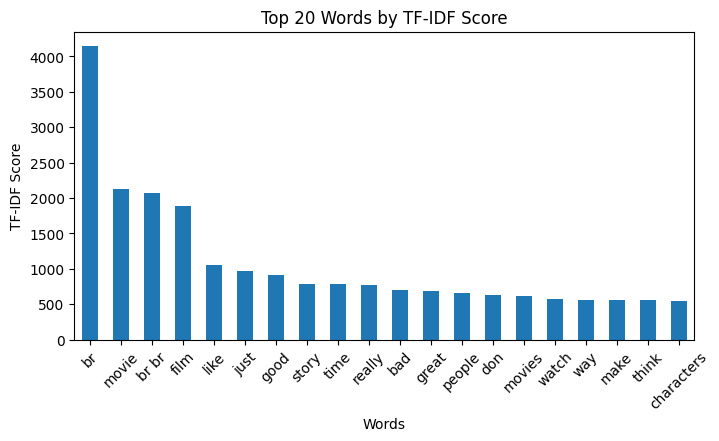

In [5]:
def bar_chart_top_n_words_with_high_tfidf(n):
    # Get feature names (words in our vocabulary)
    feature_names = np.array(vectorizer.get_feature_names_out())
    # print(feature_names[:5]) # ['10' '20' '30' '80' 'able']

    # Get the TF-IDF scores for each word in the first document
    scores = X_train_vectorized.toarray()
    # print(scores.shape) # (25000, 808)
    """ 
    [[0.         0.         0.         ... 0.         0.         0.07747023]
    [0.         0.         0.         ... 0.         0.         0.        ]
    [0.         0.         0.         ... 0.         0.         0.        ]
    ...
    ]
    """

    # Sum the TF-IDF scores for each word across all documents
    word_scores = np.sum(scores, axis=0)
    # print(word_scores) # (808,)
    """ 
    [ 407.6091415    94.16585668   87.99444704   85.53918911  145.38221937
    185.34731773  145.74034136  101.99891804  535.41810334  333.8988697
    246.49865795  412.13013595  148.34809517   98.42278875  358.25223398
    ...
    ]
    """

    # Create a DataFrame of word scores
    word_scores_df = pd.DataFrame(word_scores, index=feature_names, columns=['TF-IDF'])
    word_scores_df = word_scores_df.sort_values(by='TF-IDF', ascending=False)
    # print(word_scores_df)
    """
                    TF-IDF
    br         4143.389148
    movie      2123.105117
    br br      2075.316470
    ...                ...
    """

    # Plot the top n words
    word_scores_df.head(n).plot(kind='bar', figsize=(8, 4), legend=False)
    plt.title('Top 20 Words by TF-IDF Score')
    plt.xlabel('Words')
    plt.ylabel('TF-IDF Score')
    plt.xticks(rotation=45)
    plt.show()

bar_chart_top_n_words_with_high_tfidf(20)

Plot a histogram of how many unique words are in each review

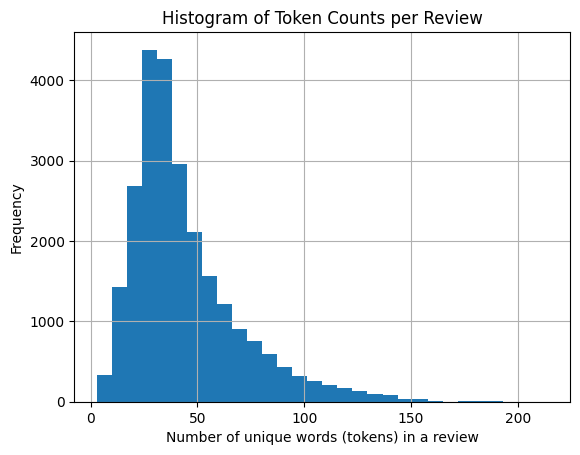

In [6]:
def review_word_count_histgram(X):
    '''
    X: Sparse matrix (e.g., TF-IDF matrix)
    '''
    token_counts = np.array([x.count_nonzero() for x in X])  # Count non-zero values in each row
    plt.hist(token_counts, bins=30)
    plt.title('Histogram of Token Counts per Review')
    plt.xlabel('Number of unique words (tokens) in a review')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

review_word_count_histgram(X_train_vectorized)

Vocabulary size: number of unique words in the training set. This is important to understand the size of the feature space.

In [7]:
print("Vocabulary Size:", len(np.array(vectorizer.get_feature_names_out())))

Vocabulary Size: 808


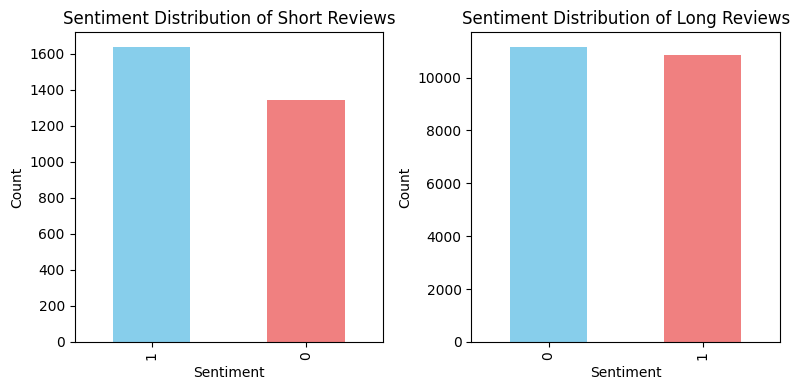

In [8]:
X_train_review_length = X_train.apply(lambda x: len(x.split()))


# Define short and long reviews based on length
short_reviews = X_train[X_train_review_length <= 100]
long_reviews = X_train[X_train_review_length > 100]

short_reviews_label = y_train[X_train_review_length <= 100]
long_reviews_label = y_train[X_train_review_length > 100]


# Plot sentiment distribution for short vs long reviews
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
short_reviews_label.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution of Short Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
long_reviews_label.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution of Long Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

           positive  negative      diff
great      0.039712  0.015265  0.024448
best       0.028664  0.013170  0.015494
love       0.028993  0.013515  0.015478
excellent  0.016516  0.003485  0.013031
wonderful  0.014278  0.002736  0.011541
life       0.025916  0.015429  0.010486
beautiful  0.014099  0.005076  0.009022
perfect    0.011713  0.003140  0.008573
amazing    0.010936  0.002467  0.008469
loved      0.011813  0.003501  0.008311


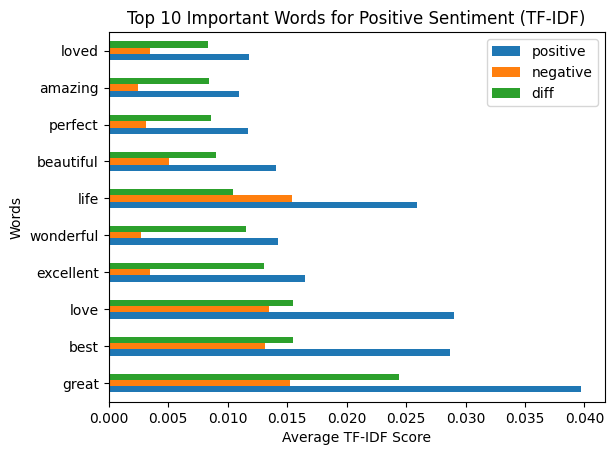

In [9]:
# Convert y_train to a numpy array (if it's a pandas Series)
y_train = np.array(y_train)

# create boolean masks for positive/negative reviews
positive_mask = y_train == 1  
negative_mask = y_train == 0  

# Index the sparse matrix using the boolean masks
positive_reviews_tfidf = X_train_vectorized[positive_mask]
negative_reviews_tfidf = X_train_vectorized[negative_mask]

# Get the average TF-IDF score for each word (feature) in positive and negative reviews
positive_avg_tfidf = np.array(positive_reviews_tfidf.mean(axis=0)).flatten()
negative_avg_tfidf = np.array(negative_reviews_tfidf.mean(axis=0)).flatten()

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Create DataFrames to compare positive and negative TF-IDF scores
df_positive = pd.DataFrame(positive_avg_tfidf, index=words, columns=['positive'])
df_negative = pd.DataFrame(negative_avg_tfidf, index=words, columns=['negative'])

# Merge DataFrames to compare positive vs negative sentiment
df_comparison = pd.concat([df_positive, df_negative], axis=1)

# Calculate the difference in TF-IDF scores between positive and negative reviews
df_comparison['diff'] = df_comparison['positive'] - df_comparison['negative']

# Sort the DataFrame by the difference to find the most important words for positive sentiment
df_comparison = df_comparison.sort_values(by='diff', ascending=False)
print(df_comparison.head(10))

# Plot the top 10 most important words for positive sentiment
df_comparison.head(10).plot(kind='barh')
plt.title('Top 10 Important Words for Positive Sentiment (TF-IDF)')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.show()

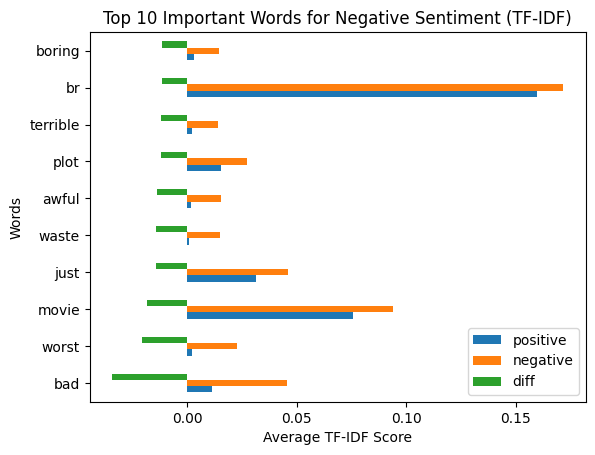

In [10]:
# Sort the DataFrame by the difference to find the most important words for negative sentiment
df_comparison = df_comparison.sort_values(by='diff', ascending=True)

# Plot the top 10 most important words for negative sentiment
df_comparison.head(10).plot(kind='barh')
plt.title('Top 10 Important Words for Negative Sentiment (TF-IDF)')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.show()

---
## Classifier experiments

---
### KNN classifier

---
### Logistic classifier

In [31]:
def logistic_classification(X_train, y_train, X_test, y_test, X_val, y_val):
    classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True,  C=50)
    classifier.fit(X_train, y_train)

    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print('\nTraining accuracy:', format(100 * train_accuracy, '.2f'))

    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print('\nTraining accuracy:', format(100 * test_accuracy, '.2f'))

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print('\nVal accuracy:', format(100 * val_accuracy, '.2f'))

    return classifier, train_accuracy, test_accuracy, val_accuracy, test_predictions

In [32]:
logistic_classifier, logistic_train_accuracy, test_accuracy, val_accuracy, test_predictions = logistic_classification(X_train_vectorized, y_train, X_test_vectorized, y_test, X_val_vectorized, y_val)


Training accuracy: 86.65

Training accuracy: 84.68

Val accuracy: 85.62


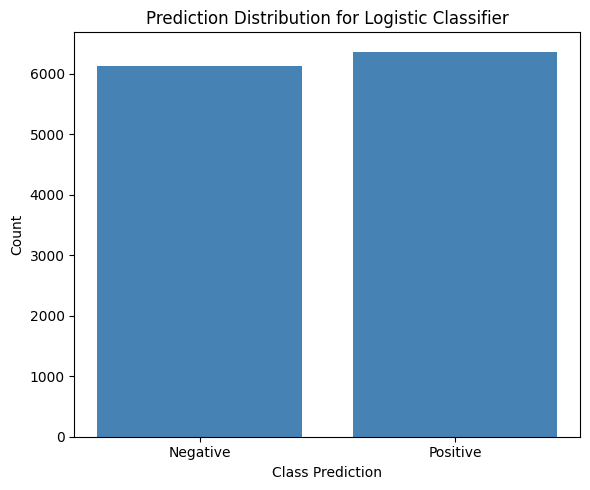

In [43]:
def plot_prediction_distribution(predictions):

    labels, counts = np.unique(predictions, return_counts=True)

    # Map numeric labels to string class names
    label_names = ['Negative' if label == 0 else 'Positive' for label in labels]

    plt.figure(figsize=(6, 5))
    plt.bar(label_names, counts, color='steelblue')

    plt.title("Prediction Distribution for Logistic Classifier")
    plt.xlabel("Class Prediction")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_prediction_distribution(test_predictions)

In [41]:

def compute_confusion_matrix(classifier, X_test, y_test):
    # Generate predictions
    y_pred = classifier.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Optional: visualize it
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

    return cm

Confusion Matrix:
[[5237 1020]
 [ 895 5348]]


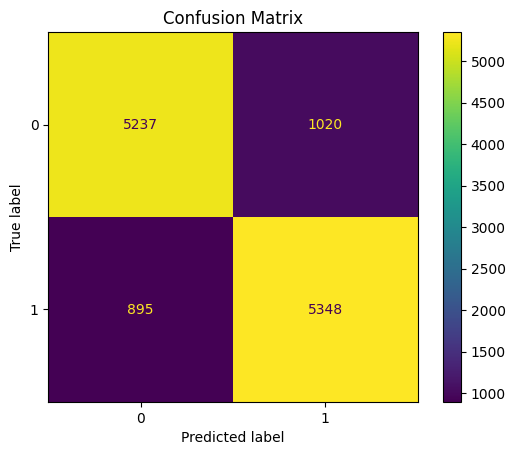

array([[5237, 1020],
       [ 895, 5348]])

In [14]:
compute_confusion_matrix(logistic_classifier, X_test_vectorized, y_test)

In [45]:
def regularization(X_train, y_train, X_val, y_val):
    coefs_ = []
    train_accuracies = []
    val_accuracies = []
    cs = [0, 0.1, 1, 10, 50, 100, 200, 500, 1000]

    ### YOUR CODE STARTS HERE ###
    for c in cs:
        # Specify the logistic classifier model
        if c == 0:
            classifier = LogisticRegression(penalty=None, fit_intercept=True)
        else:
            # Refer https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
            # to see which argument can adjust the regularization strength,
            # Additionally, please use 'l1' penalty type, 'liblinear' solver and enable fit_intercept
            classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True, C=c)

        classifier.fit(X_train, y_train)

        # log model coefficients
        coefs_.append(classifier.coef_)

        # Training
        train_predictions = classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)

        # Validation: compute and print accuracy and AUC on the validation data
        val_predictions = classifier.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_accuracies.append(val_accuracy)

    fig, axes = plt.subplots()
    axes.xaxis.set_inverted(True)
    axes.semilogx(cs, train_accuracies, color='red', label='training accuracy')
    axes.semilogx(cs, val_accuracies, color='blue', label='test accuracy')
    
    axes.set_xlabel('regularization strength', fontsize=14)
    axes.set_ylabel('accuracy', fontsize=14)
    
    axes.legend()

    return train_accuracies, coefs_


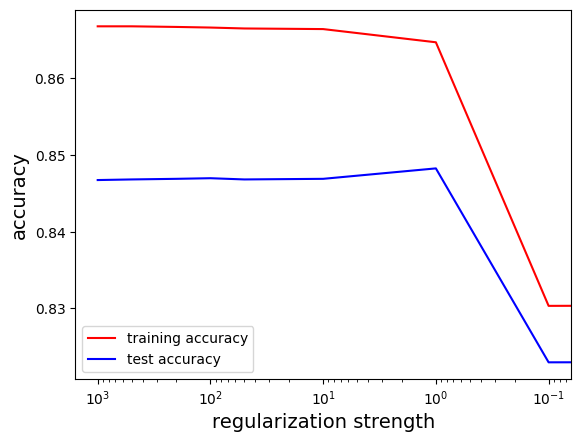

In [46]:
train_accuracies, coefs = regularization(X_train_vectorized, y_train, X_test_vectorized, y_test)

In [ ]:
from sklearn.utils import shuffle

def evaluate_logistic_with_data_sizes(X_train, y_train, X_test, y_test, data_sizes, C=1.0):
    results = []
    
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

    for size in data_sizes:
        X_sub = X_train_shuffled[:size]
        y_sub = y_train_shuffled[:size]

        model = LogisticRegression(penalty='l2', solver='liblinear', C=C)
        model.fit(X_sub, y_sub)

        train_pred = model.predict(X_sub)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_sub, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        results.append((size, train_acc, test_acc))
        print(f"Data size: {size} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
    return results

Data size: 50 | Train Acc: 0.9600 | Test Acc: 0.5332
Data size: 500 | Train Acc: 0.9500 | Test Acc: 0.7741
Data size: 2000 | Train Acc: 0.9060 | Test Acc: 0.8140
Data size: 5000 | Train Acc: 0.8836 | Test Acc: 0.8331
Data size: 10000 | Train Acc: 0.8716 | Test Acc: 0.8406
Data size: 20000 | Train Acc: 0.8649 | Test Acc: 0.8460
Data size: 25000 | Train Acc: 0.8652 | Test Acc: 0.8487


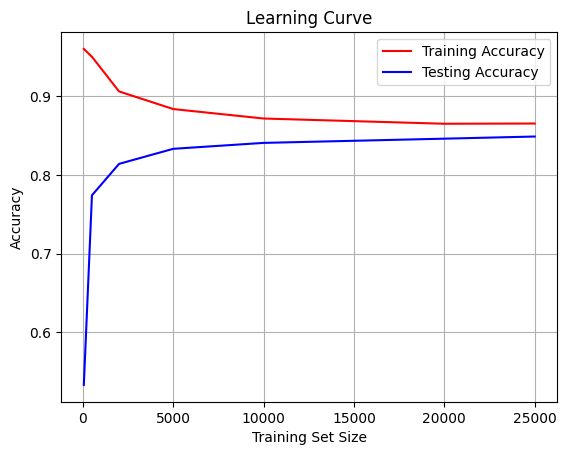

In [ ]:
data_sizes = [50, 500, 2000, 5000, 10000, 20000, 25000]
results = evaluate_logistic_with_data_sizes(X_train_vectorized, y_train, X_test_vectorized, y_test, data_sizes)

sizes, train_accs, test_accs = zip(*results)
plt.plot(sizes, train_accs, label="Training Accuracy", color='red')
plt.plot(sizes, test_accs, label="Testing Accuracy", color='blue')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

---
### Neural network classifier

---
### Experimental Result Analysis

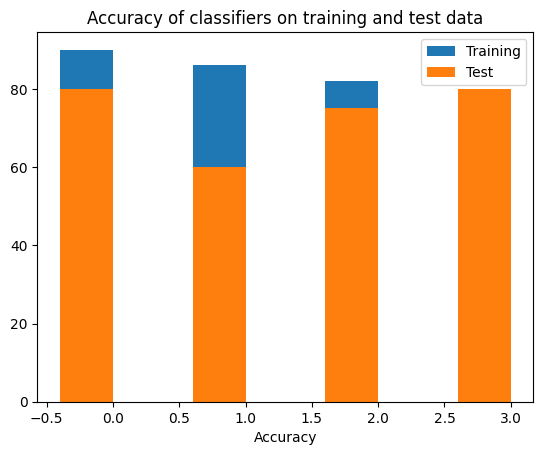

In [ ]:
def compare_classifiers(kNN, logistic, neural, naive):
    train_accuracies = [90, 86, 82, 70]
    test_accuracies = [80, 60, 75, 80]
    classifiers = ['kNN', 'Logistic', 'Feedforward Neural Network', 'Multi-nominal Naive Bayes']
    fig, ax = plt.subplots()
    w, x = 0.4, np.arange(len(classifiers))
    ax.bar(x - w/2, train_accuracies, width=w, label='Training')
    ax.bar(x - w/2, test_accuracies, width=w, label='Test')
    plt.title("Accuracy of classifiers on training and test data")
    plt.xlabel('Classifiers')
    plt.xlabel('Accuracy')
    plt.legend()
    plt.show()

compare_classifiers(0, 0, 0, 0)